In [1]:
# train an object detector inspired by the following example
# https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb

#%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::053061259712:role/service-role/AmazonSageMaker-ExecutionRole-20201027T104360


In [2]:
#bucket = sess.default_bucket() 
bucket_name = 'treetracker-training-images'
print(bucket_name)

treetracker-training-images


In [18]:
prefix = 'imnet'

In [4]:
import sagemaker.image_uris as image_uris

training_image = image_uris.retrieve('object-detection', sess.boto_region_name)

print (training_image)
print(sess.boto_region_name)

813361260812.dkr.ecr.eu-central-1.amazonaws.com/object-detection:1
eu-central-1


In [16]:
%%time
! rm data/train.* -rf   
! mkdir data
! pwd
! ls data
! pip install mxnet

# uncomment to download the dataset in the notebook
# the recordIO is already in the target S3 bucket
! python3 convert_imnet_to_recordio.py --folder "./data" --augment-horizontally 1 --prefix "aug_" --data "all"

mkdir: cannot create directory ‘data’: File exists
/home/ec2-user/SageMaker/treetracker-machine-learning/imnet/imnet_to_record_io
aug_test.idx   aug_train.lst	   aug_validation.rec  original_images
aug_test.lst   aug_train.rec	   bounding_boxes
aug_test.rec   aug_validation.idx  images.txt
aug_train.idx  aug_validation.lst  imnet.names
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
These downloads are big and may take some time... please be patient :)
Seems like judas raw images have already been downloaded. If you wish to redownload, delete the original directory with the corresponding wnid n12513613
Seems like the n12513613  annotations have already been downloaded. If you wish to redownload, delete the original directory with the corresponding wnid. 
Raw image data and bounding boxes for judas (wnid n12513613)  finished in  4.5299530029296875e-05 seconds
Seems like palm raw images have already been downl

time: 17.4171040058136  count: 1000
time: 7.473493576049805  count: 2000
time: 0.12424039840698242  count: 3000
List file ./data/aug_validation.lst generated...
Creating .rec file from /home/ec2-user/SageMaker/treetracker-machine-learning/imnet/imnet_to_record_io/data/aug_validation.lst in /home/ec2-user/SageMaker/treetracker-machine-learning/imnet/imnet_to_record_io/data
Multiprocessing not available, fall back to single threaded encoding
time: 0.00852656364440918  count: 0
List file ./data/aug_test.lst generated...
Creating .rec file from /home/ec2-user/SageMaker/treetracker-machine-learning/imnet/imnet_to_record_io/data/aug_test.lst in /home/ec2-user/SageMaker/treetracker-machine-learning/imnet/imnet_to_record_io/data
Multiprocessing not available, fall back to single threaded encoding
time: 0.011419296264648438  count: 0
Record files generated.
CPU times: user 7.03 s, sys: 2.28 s, total: 9.32 s
Wall time: 10min 3s


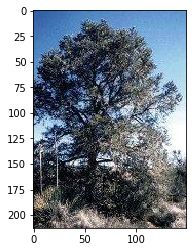

/home/ec2-user/SageMaker/treetracker-machine-learning/imnet/imnet_to_record_io


In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('data/original_images/pine/n11608250_10007.JPEG')

plt.imshow(img)
plt.show()
!pwd

In [20]:
%%time
import boto3

key_train = "{}/aug_train.rec".format(prefix)
s3_train_data = 's3://{}/{}'.format(bucket_name, key_train)
print(s3_train_data)
#boto3.Session().resource('s3').Bucket(bucket_name).Object(key_train).upload_file('data/aug_train.rec')

key_validation = "{}/aug_validation.rec".format(prefix)
s3_validation_data = 's3://{}/{}'.format(bucket_name, key_validation)
print(s3_validation_data)
#boto3.Session().resource('s3').Bucket(bucket_name).Object(key_validation).upload_file('data/aug_validation.rec')


s3://treetracker-training-images/imnet/aug_train.rec
s3://treetracker-training-images/imnet/aug_validation.rec
CPU times: user 231 µs, sys: 0 ns, total: 231 µs
Wall time: 126 µs


In [21]:
s3_output_location = 's3://{}/{}/output'.format(bucket_name, prefix)
print(s3_output_location)

s3://treetracker-training-images/imnet/output


In [22]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         instance_count=1, 
                                         instance_type='ml.p3.2xlarge',
                                         volume_size = 50,
                                         max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [23]:
num_species = 2 # tree vs nontree
my_training_samples = 2451 * 2

od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=num_species,
                             mini_batch_size=64,
                             epochs=200,
                             learning_rate=0.001,
                             lr_scheduler_step='3,6',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=350,
                             num_training_samples=my_training_samples)

In [24]:
train_data = sagemaker.session.TrainingInput(s3_train_data, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')

validation_data = sagemaker.session.TrainingInput(s3_validation_data, distribution='FullyReplicated', 
                              content_type='application/x-recordio', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data}


In [ ]:
od_model.fit(inputs=data_channels, logs=True)

2021-01-03 22:36:25 Starting - Starting the training job...
2021-01-03 22:36:50 Starting - Launching requested ML instancesProfilerReport-1609713384: InProgress
.........
2021-01-03 22:38:11 Starting - Preparing the instances for training......
2021-01-03 22:39:20 Downloading - Downloading input data
2021-01-03 22:39:20 Training - Downloading the training image......
2021-01-03 22:40:15 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[01/03/2021 22:40:18 INFO 140075079464768] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'

[01/03/2021 22:42:17 INFO 140075079464768] #quality_metric: host=algo-1, epoch=1, batch=77 train cross_entropy <loss>=(1.0502093186229755)
[01/03/2021 22:42:17 INFO 140075079464768] #quality_metric: host=algo-1, epoch=1, batch=77 train smooth_l1 <loss>=(0.5386157085402543)
[01/03/2021 22:42:17 INFO 140075079464768] Round of batches complete
[01/03/2021 22:42:17 INFO 140075079464768] Updated the metrics
[01/03/2021 22:42:22 INFO 140075079464768] #quality_metric: host=algo-1, epoch=1, validation mAP <score>=(0.027442356226338872)
[01/03/2021 22:42:22 INFO 140075079464768] Updating the best model with validation-mAP=0.027442356226338872
[01/03/2021 22:42:22 INFO 140075079464768] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[01/03/2021 22:42:22 INFO 140075079464768] #progress_metric: host=algo-1, completed 1 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "m

[01/03/2021 22:46:14 INFO 140075079464768] #quality_metric: host=algo-1, epoch=6, batch=77 train cross_entropy <loss>=(0.6741275143065796)
[01/03/2021 22:46:14 INFO 140075079464768] #quality_metric: host=algo-1, epoch=6, batch=77 train smooth_l1 <loss>=(0.3780184347376467)
[01/03/2021 22:46:14 INFO 140075079464768] Round of batches complete
[01/03/2021 22:46:15 INFO 140075079464768] Updated the metrics
[01/03/2021 22:46:19 INFO 140075079464768] #quality_metric: host=algo-1, epoch=6, validation mAP <score>=(0.25546215544395817)
[01/03/2021 22:46:19 INFO 140075079464768] Updating the best model with validation-mAP=0.25546215544395817
[01/03/2021 22:46:19 INFO 140075079464768] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[01/03/2021 22:46:19 INFO 140075079464768] #progress_metric: host=algo-1, completed 3 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max

In [ ]:
%%time
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')
object_detector.endpoint_name

In [25]:
import json
from image_utils import visualize_detection

def compute_detections(file_name):
    with open(file_name, 'rb') as image:
        f = image.read()
        b = bytearray(f)
        ne = open('n.txt','wb')
        ne.write(b)

    results = object_detector.predict(b, initial_args={'ContentType': 'image/jpeg'})
    detections = json.loads(results)
    # print (detections)

    # Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
    object_categories = ['tree', 'nontree']
    threshold = 0.5

    # Visualize the detections.
    visualize_detection(file_name, detections['prediction'], object_categories, threshold)

In [26]:
file_name = []
file_name.append('data/original_images/judas/n12513613_7251.JPEG')
file_name.append('data/original_images/judas/n12513613_7922.JPEG')
file_name.append('data/original_images/judas/n12513613_4910.JPEG')
file_name.append('data/original_images/fig/n12401684_10111.JPEG')
file_name.append('data/original_images/fig/n12401684_23162.JPEG')
file_name.append('data/original_images/fig/n12401684_2691.JPEG')
file_name.append('data/original_images/palm/n12582231_26277.JPEG')
file_name.append('data/original_images/palm/n12582231_23552.JPEG')
file_name.append('data/original_images/palm/n12582231_10693.JPEG')
file_name.append('data/original_images/pine/n11608250_21659.JPEG')
file_name.append('data/original_images/pine/n11608250_24462.JPEG')
file_name.append('data/original_images/pine/n11608250_11636.JPEG')
file_name.append('data/original_images/china tree/n12741792_12058.JPEG')
file_name.append('data/original_images/china tree/n12741792_4736.JPEG')
file_name.append('data/original_images/china tree/n12741792_693.JPEG')


In [4]:
for file in file_name:
    compute_detections(file)

FileNotFoundError: [Errno 2] No such file or directory: 'data/original_images/judas/n12513613_7251.JPEG'